In [32]:
import pandas as pd
import re
import copy
from decision_tree import DecisionTree
import numpy as np
import matplotlib.pyplot as plt

2. [36 points] We will implement the boosting and bagging algorithms based on decision
trees. Let us test them on the bank marketing dataset in HW1 (bank.zip in Canvas).
We use the same approach to convert the numerical features into binary ones. That
is, we choose the media (NOT the average) of the attribute values (in the training set)
as the threshold, and examine if the feature is bigger (or less) than the threshold. For
simplicity, we treat “unknown” as a particular attribute value, and hence we do not
have any missing attributes for both training and test.

In [33]:
bank_column_names = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
bank_attributes = {
    'age': ['numeric'],
    'job': ['admin.', 'unknown', 'unemployed', 'management', 'housemaid', 'entrepreneur', 'student', 'blue-collar', 'self-employed', 'retired', 'technician', 'services'],
    'marital': ['married', 'divorced', 'single'],
    'education': ['unknown', 'secondary', 'primary', 'tertiary'],
    'default': ['yes', 'no'],
    'balance': ['numeric'],
    'housing': ['yes', 'no'],
    'loan': ['yes', 'no'],
    'contact': ['unknown', 'telephone', 'cellular'],
    'day': ['numeric'],
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    'duration': ['numeric'],
    'campaign': ['numeric'],
    'pdays': ['numeric'],
    'previous': ['numeric'],
    'poutcome': ['unknown', 'other', 'failure', 'success'],
}

bank_train = pd.read_csv('../data/bank-4/train.csv', names=bank_column_names)
bank_test = pd.read_csv('../data/bank-4/test.csv', names=bank_column_names)

X_bank_train = bank_train.drop('y', axis=1)
y_bank_train = bank_train['y']
y_bank_train = y_bank_train.replace(('yes', 'no'), (1, -1))

X_bank_test = bank_test.drop('y', axis=1)
y_bank_test = bank_test['y']
y_bank_test = y_bank_test.replace(('yes', 'no'), (1, -1))


# bank_training_data = pd.read_csv('../data/bank-4/train.csv', names=bank_column_names)
# bank_testing_data = pd.read_csv('../data/bank-4/test.csv', names=bank_column_names)
# bank_training_labels = bank_training_data.iloc[:, -1]
# bank_testing_labels = bank_testing_data.iloc[:, -1]

# bank_training_data.y.replace(('yes', 'no'), (1, -1), inplace=True)
# bank_testing_data.y.replace(('yes', 'no'), (1, -1), inplace=True)

# bank_training_labels = bank_training_data.iloc[:, -1]
# bank_testing_labels = bank_testing_data.iloc[:, -1]


(a) [8 points] Modify your decision tree learning algorithm to learn decision stumps
— trees with only two levels. Specifically, compute the information gain to select
the best feature to split the data. Then for each subset, create a leaf node. Note
that your decision stumps must support weighted training examples. Based on
your decision stump learning algorithm, implement AdaBoost algorithm. Vary the 
number of iterations T from 1 to 500, and examine the training and test errors.
You should report the results in two figures. The first figure shows how the
training and test errors vary along with T. The second figure shows the training
and test errors of all the decision stumps learned in each iteration. What can you
observe and conclude? You have had the results for a fully expanded decision tree
in HW1. Comparing them with Adaboost, what can you observe and conclude?

In [39]:

initial_weights_value = 1 / len(y_bank_train)
initial_weights = pd.DataFrame({'weights': [initial_weights_value] * len(y_bank_train)})
boosting_learner = {}

boosting_dt = DecisionTree(boosting=True, T=500, weights=initial_weights)
boosting_dt.fit(X_bank_train, bank_attributes, y_bank_train)
# boosting_learner[i] = copy.deepcopy(boosting_dt)



In [40]:
train_error_T = {}
test_error_T = {}

train_error_stump = {}
test_error_stump = {}

#Error for T
for i in range(0, 500):
    bank_train_predictions = boosting_dt.predict(X_bank_train, bank_attributes, num_trees=i+1)
    bank_test_predictions = boosting_dt.predict(X_bank_test, bank_attributes, num_trees=i+1)

    train_error_T[i] = (bank_train_predictions.label != y_bank_train).sum() / len(y_bank_train)
    test_error_T[i] = (bank_test_predictions.label != y_bank_test).sum() / len(y_bank_test)

#Error for Stump
train_error_stump = boosting_dt.get_stumps_train_error()
decision_stump = boosting_dt.get_decision_stumps()

for i in range(len(decision_stump)):
    bank_test_predictions = boosting_dt.predict(X_bank_test, bank_attributes, decision_tree=decision_stump[i][0])
    test_error_stump[i] = (bank_test_predictions.label != y_bank_test).sum() / len(y_bank_test)

    


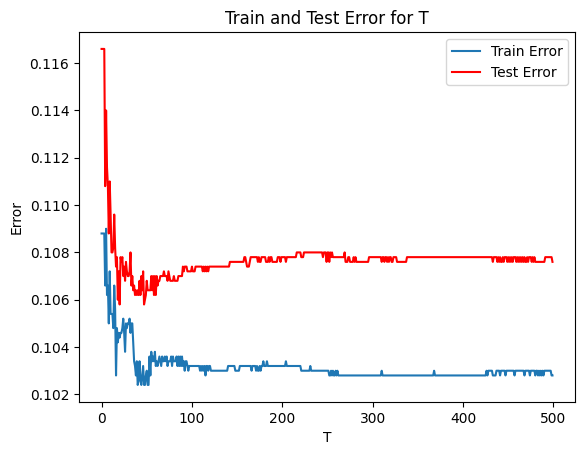

In [41]:
#Train and test error for T
plt.plot(list(train_error_T.keys()), list(train_error_T.values()), label='Train Error')
plt.plot(list(test_error_T.keys()), list(test_error_T.values()), label='Test Error', color='red')
plt.xlabel('T')
plt.ylabel('Error')
plt.title('Train and Test Error for T')
plt.legend()
plt.show()

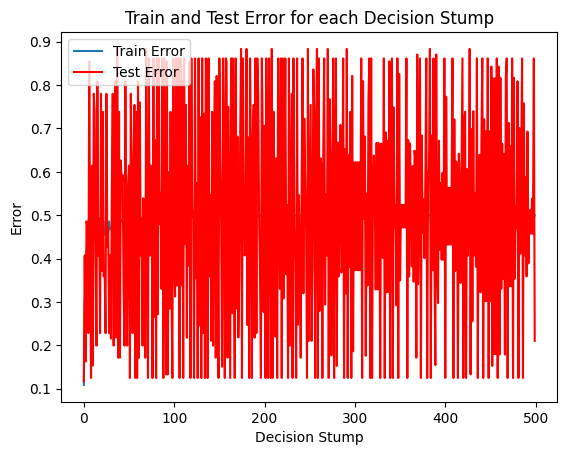

In [42]:
#Train and test error for each Decision Stump
plt.plot(list(train_error_stump.keys()), list(train_error_stump.values()), label='Train Error')
plt.plot(list(test_error_stump.keys()), list(test_error_stump.values()), label='Test Error', color='red')
plt.xlabel('Decision Stump')
plt.ylabel('Error')
plt.title('Train and Test Error for each Decision Stump')
plt.legend()
plt.show()

(b) [8 points] Based on your code of the decision tree learning algorithm (with information gain), implement a Bagged trees learning algorithm. Note that each tree
should be fully expanded — no early stopping or post pruning. Vary the number
of trees from 1 to 500, report how the training and test errors vary along with the
tree number in a figure. Overall, are bagged trees better than a single tree? Are
bagged trees better than Adaboost?

In [43]:
bagged_dt = DecisionTree(bagging=True, T=500)
bagged_dt.fit(X_bank_train, bank_attributes, y_bank_train,  sample_frac=1, replacement=True)

bagged_train_error = {}
bagged_test_error = {}

for i in range(0, 500):
    bagged_train_predictions = bagged_dt.predict(X_bank_train, bank_attributes, num_trees=i+1)
    bagged_test_predictions = bagged_dt.predict(X_bank_test, bank_attributes, num_trees=i+1)

    bagged_train_error[i] = (bagged_train_predictions.label != y_bank_train).sum() / len(y_bank_train)
    # print(bagged_train_error[i])
    bagged_test_error[i] = (bagged_test_predictions.label != y_bank_test).sum() / len(y_bank_test)
    # print(bagged_test_error[i])

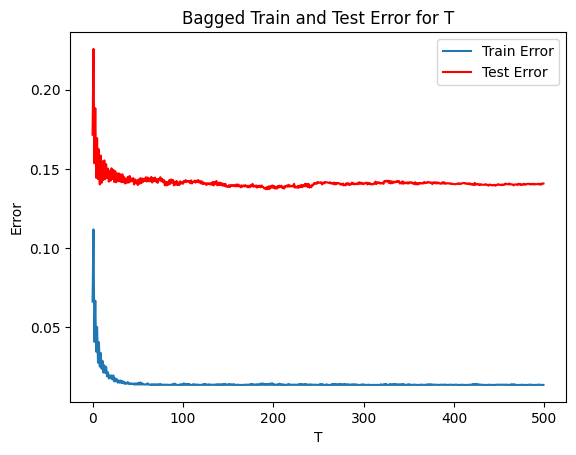

In [44]:
#Bagged Train and test error for T
plt.plot(list(bagged_train_error.keys()), list(bagged_train_error.values()), label='Train Error')
plt.plot(list(bagged_test_error.keys()), list(bagged_test_error.values()), label='Test Error', color='red')
plt.xlabel('T')
plt.ylabel('Error')
plt.title('Bagged Train and Test Error for T')
plt.legend()
plt.show()

(c) [6 points] Through the bias and variance decomposition, we have justified why
the bagging approach is more effective than a single classifier/predictor. Let us
verify it in real data. Experiment with the following procedure.
•REPEAT for 100 times
•[STEP 1] Sample 1,000 examples uniformly without replacement from the
training datset
•[STEP 2] Run your bagged trees learning algorithm based on the 1,000
training examples and learn 500 trees.
•END REPEAT
•Now you have 100 bagged predictors in hand. For comparison, pick the first
tree in each run to get 100 fully expanded trees (i.e. single trees).
•For each of the test example, compute the predictions of the 100 single trees.
Take the average, subtract the ground-truth label, and take square to compute
the bias term (see the lecture slides). Use all the predictions to compute the
sample variance as the approximation to the variance term (if you forget
what the sample variance is, check it out here). You now obtain the bias
and variance terms of a single tree learner for one test example. You will
need to compute them for all the test examples and then take average as
your final estimate of the bias and variance terms for the single decision tree
learner. You can add the two terms to obtain the estimate of the general
squared error (that is, expected error w.r.t test examples). Now use your 100
bagged predictors to do the same thing and estimate the general bias and
variance terms, as well as the general squared error. Comparing the results
of the single tree learner and the bagged trees, what can you conclude? What
causes the difference?



In [46]:

single_trees = []
single_trees_predictions = {}
single_trees_predictions_variance = np.zeros((len(y_bank_test)))
single_trees_prediction_totals = np.zeros((len(y_bank_test)))

bagged_dts = {}
bagged_trees_predictions = {}
bagged_trees_predictions_variance = np.zeros((len(y_bank_test)))
bagged_trees_prediction_totals = np.zeros((len(y_bank_test)))

for i in range(0, 100):
    print('creating bagged tree: ', i)
    bagged_dt = DecisionTree(bagging=True, T=500)
    bagged_dt.fit(X_bank_train, bank_attributes, y_bank_train, sample_size=1000, replacement=False)
    bagged_dts[i] = copy.deepcopy(bagged_dt)

#get first tree from each bagged_dt


dt = DecisionTree()

for i in range(0, 100):
    print('creating single tree: ', i)
    bagged_trees = bagged_dts[i].get_bagged_trees()
    single_trees.append(bagged_trees[i])

for i in range(len(single_trees)):
    tree = single_trees[i]
    single_trees_prediction = dt.predict(X_bank_test, bank_attributes, decision_tree=tree)
    single_trees_prediction_totals += single_trees_prediction.label
    single_trees_predictions[i] = single_trees_prediction.label

    bagged_trees = bagged_dts[i]
    bagged_trees_prediction = bagged_trees.predict(X_bank_test, bank_attributes, num_trees=1)
    bagged_trees_prediction_totals += bagged_trees_prediction.label
    bagged_trees_predictions[i] = bagged_trees_prediction.label



single_trees_prediction_mean = single_trees_prediction_totals / len(single_trees)
single_trees_prediction_bias = np.square((single_trees_prediction_mean - y_bank_test))

bagged_trees_prediction_mean = bagged_trees_prediction_totals / len(bagged_dts)
bagged_trees_prediction_bias = np.square((bagged_trees_prediction_mean - y_bank_test))

for i in range(len(single_trees)):
    print('predicting: ', i)
    for j in range(len(single_trees_predictions[i])):
        single_trees_predictions_variance[j] += np.square(single_trees_predictions[i][j] - single_trees_prediction_mean[j])
        bagged_trees_predictions_variance[j] += np.square(bagged_trees_predictions[i][j] - bagged_trees_prediction_mean[j])

single_trees_prediction_variance = single_trees_predictions_variance / len(single_trees)
single_trees_final_bias_estimate = np.sum(single_trees_prediction_bias) / len(single_trees_prediction_bias)
single_trees_final_variance_estimate = np.sum(single_trees_prediction_variance) / len(single_trees_prediction_variance)
single_trees_gen_square_error = single_trees_final_bias_estimate + single_trees_final_variance_estimate

bagged_trees_prediction_variance = bagged_trees_predictions_variance / len(bagged_dts)
bagged_trees_final_bias_estimate = np.sum(bagged_trees_prediction_bias) / len(bagged_trees_prediction_bias)
bagged_trees_final_variance_estimate = np.sum(bagged_trees_prediction_variance) / len(bagged_trees_prediction_variance)
bagged_trees_gen_square_error = bagged_trees_final_bias_estimate + bagged_trees_final_variance_estimate

print('single_trees_final_bias_estimate: ', single_trees_final_bias_estimate)
print('single_trees_final_variance_estimate: ', single_trees_final_variance_estimate)
print('single_trees_gen_square_error: ', single_trees_gen_square_error)
print('\n')
print('bagged_trees_final_bias_estimate: ', bagged_trees_final_bias_estimate)
print('bagged_trees_final_variance_estimate: ', bagged_trees_final_variance_estimate)
print('bagged_trees_gen_square_error: ', bagged_trees_gen_square_error)


creating bagged tree:  0
creating bagged tree:  1


(d) [8 points] Implement the random forest algorithm as we discussed in our lecture.
Vary the number of random trees from 1 to 500. Note that you need to modify
your tree learning algorithm to randomly select a subset of features before each
split. Then use the information gain to select the best feature to split. Vary the
size of the feature subset from {2,4,6}. Report in a figure how the training and
test errors vary along with the number of random trees for each feature subset
size setting. How does the performance compare with bagged trees?

In [ ]:
feature_subset_size = [2, 4, 6]
random_forest = {}

random_forest_dt = DecisionTree(random_forest=True, T=500)
for size in feature_subset_size:
    random_forest_dt.fit(X_bank_train, bank_attributes, y_bank_train, feature_size=size, replacement=True, sample_frac=0.25)
    random_forest[size] = copy.deepcopy(random_forest_dt)

random_forest_train_error = {2: {}, 4: {}, 6: {}}
random_forest_test_error = {2: {}, 4: {}, 6: {}}

for size in feature_subset_size:
    for i in range(0, 5):
        random_forest_train_predictions = random_forest[size].predict(X_bank_train, bank_attributes, num_trees=i+1)
        random_forest_test_predictions = random_forest[size].predict(X_bank_test, bank_attributes, num_trees=i+1)

        random_forest_train_error[size][i] = (random_forest_train_predictions.label != y_bank_train).sum() / len(y_bank_train)
        random_forest_test_error[size][i] = (random_forest_test_predictions.label != y_bank_test).sum() / len(y_bank_test)


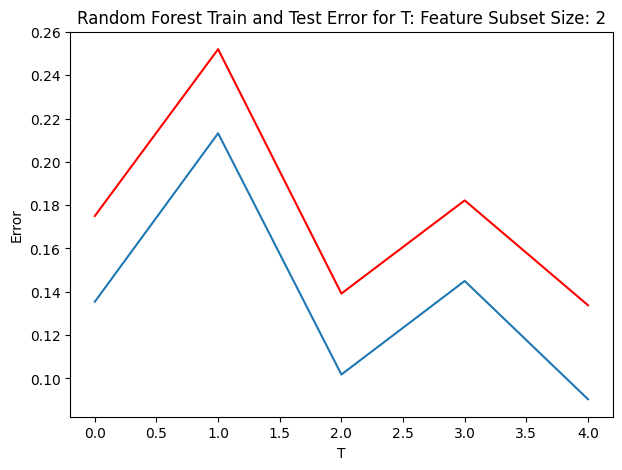

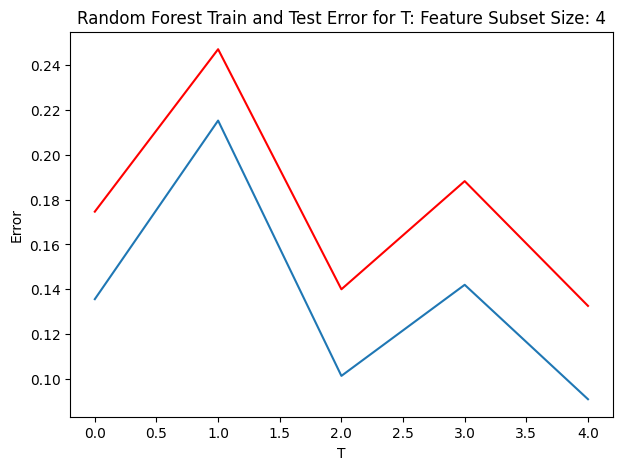

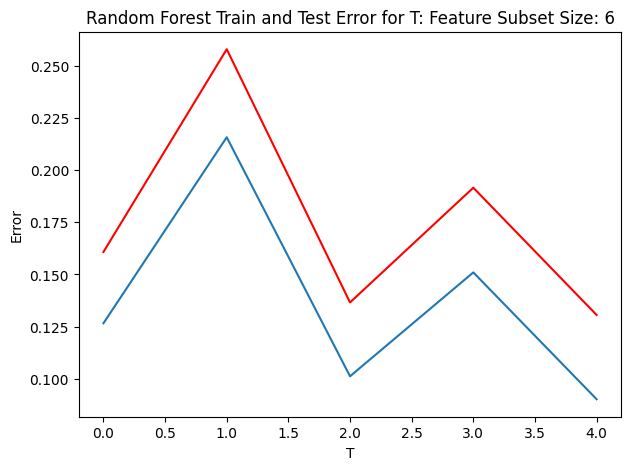

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(list(random_forest_train_error[2].keys()), list(random_forest_train_error[2].values()))
plt.plot(list(random_forest_test_error[2].keys()), list(random_forest_test_error[2].values()), color='red')

plt.xlabel('T')
plt.ylabel('Error')
plt.title('Random Forest Train and Test Error for T: Feature Subset Size: {}'.format(2))

# figure 2
plt.figure(figsize=(7, 5))

plt.plot(list(random_forest_train_error[4].keys()), list(random_forest_train_error[4].values()))
plt.plot(list(random_forest_test_error[4].keys()), list(random_forest_test_error[4].values()), color='red')

plt.xlabel('T')
plt.ylabel('Error')
plt.title('Random Forest Train and Test Error for T: Feature Subset Size: {}'.format(4))

# figure 3
plt.figure(figsize=(7, 5))

plt.plot(list(random_forest_train_error[6].keys()), list(random_forest_train_error[6].values()))
plt.plot(list(random_forest_test_error[6].keys()), list(random_forest_test_error[6].values()), color='red')

plt.xlabel('T')
plt.ylabel('Error')
plt.title('Random Forest Train and Test Error for T: Feature Subset Size: {}'.format(6))

plt.show()


(e) [6 points] Following (c), estimate the bias and variance terms, and the squared
error for a single random tree and the whole forest. Comparing with the bagged
trees, what do you observe? What can you conclude?

3. [Bonus][10 points] In practice, to confirm the performance of your algorithm, you
need to find multiple datasets for test (rather than one). You need to extract and
process data by yourself. Now please use the credit default dataset in UCI repos-
itory https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. Ran-
domly choose 24000 examples for training and the remaining 6000 for test. Feel free to
deal with continuous features. Run bagged trees, random forest, and Adaboost with
decision stumps algorithms for 500 iterations. Report in a figure how the training and
test errors vary along with the number of iterations, as compared with a fully expanded
single decision tree. Are the results consistent with the results you obtained from the
bank dataset?